In [1]:
%matplotlib inline 
from IPython.display import display, HTML
import pandas as pd 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import matplotlib as mpl 
import os 
import numpy as np 
import pylab as pl
import scipy.stats as st
import glob 
from ifis_tools import database_tools as db
from ifis_tools import series_tools as ser
import hydroeval as heval
from multiprocessing import Pool
import _pickle as cPickle

In [238]:
def Scatter(X, Y, Color = 'blue', multiple = False,size = 15,
    xLabel = '', yLabel = '', width = 300, height = 250,
    Xtype='', Ytype='', rangoX = None, rangoY = None, Texto = None, Nombres = None):
    data = []
    if multiple:
        for x,y,c,t,n in zip(X,Y,Color,Texto, Nombres):
            #Scatter RCobs Vs RCmodel
            trace = go.Scatter(
                x = x,
                y = y,
                mode = 'markers',
                name = n,
                text = t,
                marker = dict(
                    color = c,
                    size = size
                    ),
                )
            data.append(trace)
    else:        
        #Scatter RCobs Vs RCmodel
        trace = go.Scatter(
            x = x,
            y = y,
            mode = 'markers',
            name = 'name',
            marker = dict(
                color = Color,
                size = size
                ),
            )
        data.append(trace)
    if rangoX is None: rangoX = [np.min(X), np.max(X)]
    if rangoY is None: rangoY = [np.min(Y), np.max(Y)]
        
    layout = go.Layout(
        width=width,
        height=height,    
        yaxis=dict(
            title=yLabel,
            type = Ytype,
            range = rangoY,
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = xLabel,
            type = Xtype,
            range = rangoX,
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
            ),),
        margin=dict(
            l=60,
            r=50,
            b=40,
            t=20,
            pad=4
        ),
    )
    config={'showLink': False}
    fig = go.Figure(data=data,layout=layout)
    iplot(fig, config = config)
    div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    return div, fig

def CreateColorbar(colorList,ticks,path,jump=2, label = ''):
    fig, ax = pl.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    cmap = mpl.colors.ListedColormap(colorList)
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    bounds = np.arange(1,len(colorList)+2).tolist()#[1, 2, 3, 4,5,6]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    boundaries=[0] + bounds + [1],
                                    extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    cb2.set_label(label, size = 16)
    cb2.set_ticks(np.arange(1.5,len(colorList)+2.5).tolist()[::jump])
    cb2.ax.set_xticklabels(ticks[::jump], size = 15)
    fig.show()
    pl.savefig(path, bbox_inches = 'tight')

In [210]:
updatemenus=list([
    # drop-down 1: map styles menu
    # buttons containes as many dictionaries as many alternative map styles I want to offer
    dict(
        buttons=list([
            dict(
                args=['mapbox.style', 'light'],
                label='Light',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'dark'],
                label='Dark',
                method='relayout'
            ),                                
            dict(
                args=['mapbox.style', 'outdoors'],
                label='Outdoors',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'satellite-streets'],
                label='Satellite with Streets',
                method='relayout'
            )                    
        ]),
        # direction where I want the menu to expand when I click on it
        direction = 'up',
      
        # here I specify where I want to place this drop-down on the map
        x = 0.75,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
      
        # specify font size and colors
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    ), 
    # drop-down 2: select type of storm event to visualize
    dict(
         # for each button I specify which dictionaries of my data list I want to visualize. Remember I have 7 different
         # types of storms but I have 8 options: the first will show all of them, while from the second to the last option, only
         # one type at the time will be shown on the map
         buttons=list([
            dict(label = 'Kling Gupta',
                 method = 'update',
                 args = [{'visible': [True, False, False, False]}]),
            dict(label = 'Tl from Kg',
                 method = 'update',
                 args = [{'visible': [False, True, False, False]}]),
            dict(label = 'Nash',
                 method = 'update',
                 args = [{'visible': [False, False, True, False]}]),          
            dict(label = 'Tl from Ne',
                 method = 'update',
                 args = [{'visible': [False, False, False, True]}]),          
        ]),
        # direction where the drop-down expands when opened
        direction = 'up',
        # positional arguments
        x = 0.01,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
        # fonts and border
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    )

])
def PlotMap(data, updatemenus, imageDict = []):
    mapbox_access_token = 'pk.eyJ1Ijoibmljb2xhczk5OCIsImEiOiJjanNvcm02OHMwcHhhNDltcDk0Yzhlc2NkIn0.BoQ8-blC4FoYJQr0wMHVmQ'
    layout = go.Layout(
        width=850,
        height=650,    
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=42.,
                lon=-93.6
            ),
            # we want the map to be "parallel" to our screen, with no angle
            pitch = 0,
            # default level of zoom
            zoom = 6.2,
            # default map style
            style = 'light'
        ),
       margin=dict(
        l=60,
        r=50,
        b=40,
        t=20,
        pad=4
        ),
       images= imageDict,
    )
    layout['updatemenus'] = updatemenus

    fig = dict(data=data, layout=layout)

    iplot(fig, filename='Montreal Mapbox')
    div = plot(fig, include_plotlyjs=False, output_type='div')
    return div 

In [4]:
def ReadPickle(path):
    f = open(path, 'rb')
    Qobs = cPickle.load(f)
    Qsim = cPickle.load(f)
    Events = cPickle.load(f)
    f.close()
    return Qobs, Qsim, Events

In [5]:
Prop = pd.read_msgpack('/media/nicolas/Data/RunoffExp/Results/BasinsProperties.msg')
path = '/media/nicolas/Data/RunoffExp/Results/Process/'

In [182]:
%%time
RCqual = {}
Lat = []
Lon = []
Area = []
LinkId = []
BestTlKG = []
KGval = []
BestTlNE = []
NEval = []
#for link in Prop['area'][Prop['area']<2500].index:
for link in Prop.index:
    try:
        #Read data
        Qobs, Qsim, Events = ReadPickle(path + 'RC_'+link+'.bin')
        
        #Obtain based on RC dispersion
        valK = -1
        valN = -1
        for k in Qsim[link].keys():
            if np.nanmean(Qsim[link][k]['KG']) > valK:
                tlk = k
                valK = np.nanmean(Qsim[link][k]['KG'])
            if np.nanmean(Qsim[link][k]['NE']) > valN:
                tln = k
                valN = np.nanmean(Qsim[link][k]['NE'])
        BestTlKG.append(tlk)
        KGval.append(valK)
        BestTlNE.append(tln)
        NEval.append(valN)
        
        #Coord and link ID
        Lat.append(Prop['coord'][link][0])
        Lon.append(Prop['coord'][link][1])
        Area.append(Prop['area'][link])
        LinkId.append(link)
    except:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning:

Mean of empty slice



CPU times: user 734 ms, sys: 493 ms, total: 1.23 s
Wall time: 1.22 s


In [183]:
BestTlKG = np.array(BestTlKG)
BestTlNE = np.array(BestTlNE)
Lat = np.array(Lat)
Lon = np.array(Lon)
LinkId = np.array(LinkId)
KGval = np.array(KGval)
NEval = np.array(NEval)

## Bar histogram of model ocurrences selected from KG and NE

In [211]:
coloresMo = ['#614B12','#ED7511','#346D0D','#2A5BAC','#C80C2E']

ColorKG = np.array(np.zeros(BestTlKG.size), dtype='str')
for col, model in zip(coloresMo, ['01','009','007','005','003']):
    ColorKG[BestTlKG == model] = col
    
ColorNE = np.array(np.zeros(BestTlNE.size), dtype='str')
for col, model in zip(coloresMo, ['01','009','007','005','003']):
    ColorNE[BestTlNE == model] = col

coloresEF = ['#0A369C','#508DBA','#88AECA','#C9D8E3','#FCFDFE','#F3D9D5','#EEACA2','#E86653','#AA2714']

#Analysis of Kling-Gupta.
KGval[KGval<0] = 0.0
rangoKG = np.linspace(0,1,9)
KGColors = []
for k in KGval:
    for b1, b2, c in zip(rangoKG[:-1], rangoKG[1:], coloresEF):
        if k >= b1 and k <= b2:
            KGColors.append(c)
#KGsize = np.array(KGsize)

#Analysis of Nash.
NEval[NEval<-1] = -0.99
rangoNE = np.linspace(-1,1,9)
NEColors=[]
for k in NEval:
    for b1, b2,c in zip(rangoNE[:-1], rangoNE[1:], coloresEF):
        if k >= b1 and k <= b2:
            NEColors.append(c)
#NEsize = np.array(NEsize)


In [212]:
TextoKG = np.array(['kg: %.2f Tl: %s' % (j,i) for i,j in zip(BestTlKG, KGval)])
TextoNE = np.array(['Ne: %.2f Tl: %s' % (j,i) for i,j in zip(BestTlNE, NEval)])

In [ ]:
CreateColorbar(coloresMo, ['01','009','007','005','003'],'BestTlValue.png', jump=1, label='Best Tl Value')

In [ ]:
CreateColorbar(coloresEF,np.linspace(0,1,9), 'PerformanceKG.png', label='Kling-Gupta')
CreateColorbar(coloresEF,np.linspace(-1,1,9), 'PerformanceNE.png', label = 'Nash')

In [213]:
data = []

# Klin-Gupta colors by performance and by model 
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = TextoKG,
    name = 'Klin-Gupta',
    mode='markers',
    marker=dict(
        size= 15, #KGsize*3.5,
        color = KGColors,
    ),
)
data.append(event_data)

event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = TextoKG,
    name = 'Tl kg',
    mode='markers',
    visible = False,
    marker=dict(
        size= 15, #KGsize*3.5,
        color = ColorKG,
    ),
)
data.append(event_data)

# Nash colors by performance and by model 
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = TextoNE,
    name = 'Nash',
    mode='markers',
    visible = False,
    marker=dict(
        size=15, #NEsize*3.5,
        color = NEColors,
    ),
)
data.append(event_data)

event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = TextoNE,
    name = 'Tl NE',
    mode='markers',
    visible = False,
    marker=dict(
        size= 15, #KGsize*3.5,
        color = ColorNE,
    ),
)
data.append(event_data)

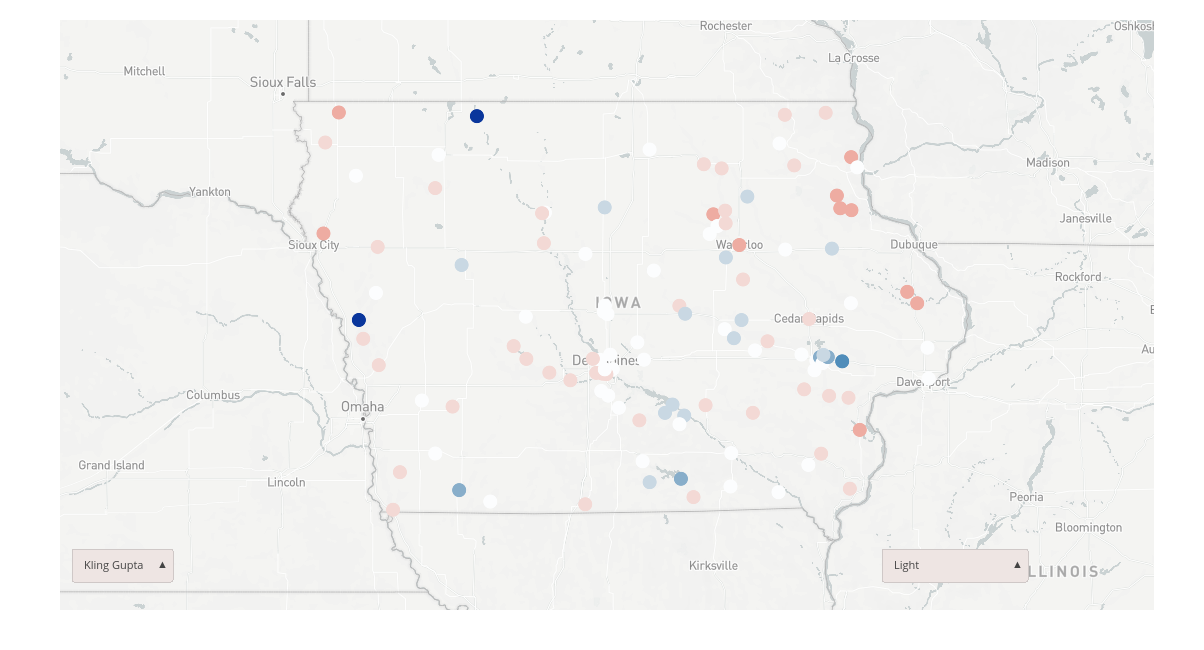

In [214]:
div = PlotMap(data, updatemenus)

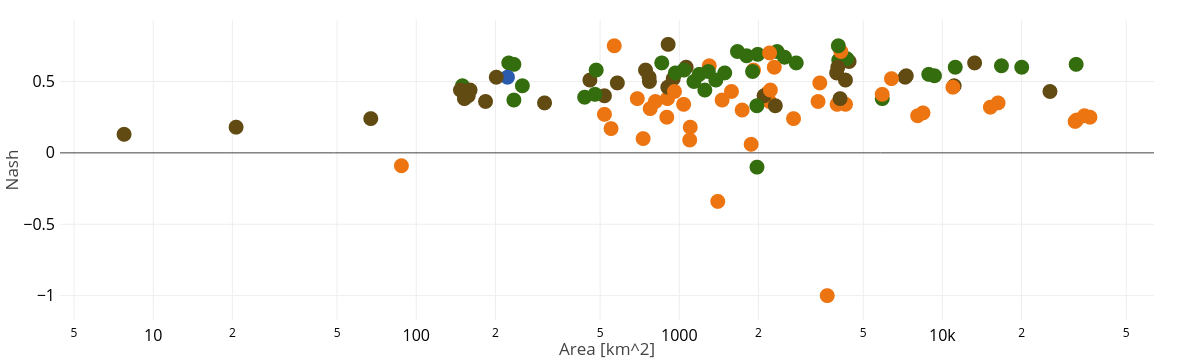

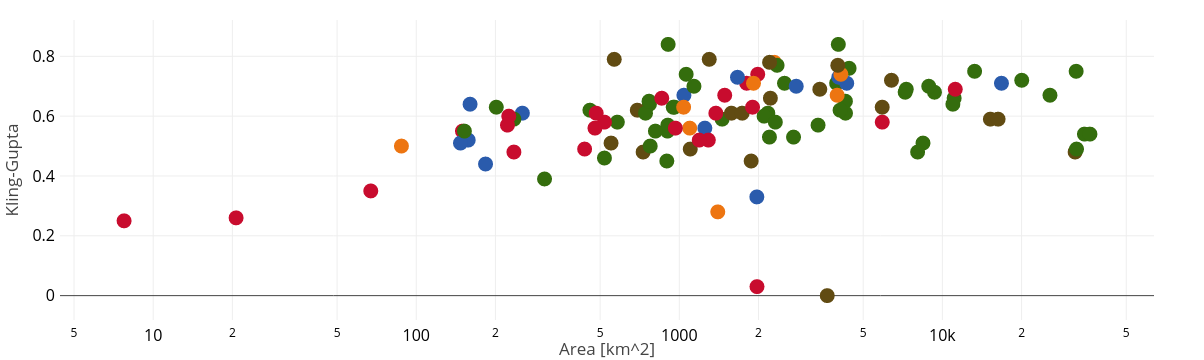

In [216]:
A = ['%.2f'%i for i in Area]; A = [float(i) for i in A]
N = ['%.2f'%i for i in NEval]; N = [float(i) for i in N]
minV = np.log(A).min(); maxV = np.log(A).max()
div, fig = Scatter(A, N, Color=ColorNE, width=500,height=300, xLabel='Area [km^2]', yLabel='Nash', Xtype='log',rangoX=None, rangoY=None)

K = ['%.2f'%i for i in KGval]; K = [float(i) for i in K]
div2, fig = Scatter(A, K, Color=ColorKG, width=500,height=300, xLabel='Area [km^2]', yLabel='Kling-Gupta', Xtype='log')


# RC analysis 

In [219]:
updatemenus=list([
    # drop-down 1: map styles menu
    # buttons containes as many dictionaries as many alternative map styles I want to offer
    dict(
        buttons=list([
            dict(
                args=['mapbox.style', 'light'],
                label='Light',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'dark'],
                label='Dark',
                method='relayout'
            ),                                
            dict(
                args=['mapbox.style', 'outdoors'],
                label='Outdoors',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'satellite-streets'],
                label='Satellite with Streets',
                method='relayout'
            )                    
        ]),
        # direction where I want the menu to expand when I click on it
        direction = 'up',
      
        # here I specify where I want to place this drop-down on the map
        x = 0.75,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
      
        # specify font size and colors
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    ), 
    # drop-down 2: select type of storm event to visualize
    dict(
         # for each button I specify which dictionaries of my data list I want to visualize. Remember I have 7 different
         # types of storms but I have 8 options: the first will show all of them, while from the second to the last option, only
         # one type at the time will be shown on the map
         buttons=list([
            dict(label = 'Mean RC obs',
                 method = 'update',
                 args = [{'visible': [True,False, False, False, False]}]),
            dict(label = 'Mean RC sim KG',
                 method = 'update',
                 args = [{'visible': [False,True, False, False, False]}]),
             dict(label = 'Relative error KG',
                 method = 'update',
                 args = [{'visible': [False,False, True, False, False]}]),
             dict(label = 'Mean RC sim NE',
                 method = 'update',
                 args = [{'visible': [False,False, False, True, False]}]),
             dict(label = 'Relative error NE',
                 method = 'update',
                 args = [{'visible': [False,False, False, False, True]}]),
        ]),
        # direction where the drop-down expands when opened
        direction = 'up',
        # positional arguments
        x = 0.01,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
        # fonts and border
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    )

])

In [220]:
%%time
RCqual = {}
RCmean = []
RCstd = []
Lat = []
Lon = []
LinkId = []
BestTlKG = []
KGval = []
BestTlNE = []
NEval = []
Nevents = []
RCbestKGMean = []
RCbestNEMean = []
RCbestKGStd = []
RCbestNEStd = []

for link in Prop['area'][Prop['area']<2500].index:
    try:
        #Read data
        Qobs, Qsim, Events = ReadPickle(path + 'RC_'+link+'.bin')
        
        #Obtain based on RC dispersion
        valK = -1
        valN = -1
        for k in Qsim[link].keys():
            if np.nanmean(Qsim[link][k]['KG']) > valK:
                tlk = k
                valK = np.nanmean(Qsim[link][k]['KG'])
            if np.nanmean(Qsim[link][k]['NE']) > valN:
                tln = k
                valN = np.nanmean(Qsim[link][k]['NE'])
        BestTlKG.append(tlk)
        KGval.append(valK)
        BestTlNE.append(tln)
        NEval.append(valN)
        RCbestKGMean.append(Qsim[link][tlk]['RC'].mean())
        RCbestKGStd.append(Qsim[link][tlk]['RC'].std())
        RCbestNEMean.append(Qsim[link][tln]['RC'].mean())
        RCbestNEStd.append(Qsim[link][tln]['RC'].std())
        Nevents.append(Qobs[link]['RC'].size)
        RCmean.append(Qobs[link]['RC'].mean())
        RCstd.append(Qobs[link]['RC'].std())
        
        #Coord and link ID
        Lat.append(Prop['coord'][link][0])
        Lon.append(Prop['coord'][link][1])
        LinkId.append(link)
    except:
        pass

CPU times: user 496 ms, sys: 326 ms, total: 822 ms
Wall time: 820 ms


In [221]:
def Remuestreador(Data, rango, val2change):
    NewData = []
    for k in Data:
        for b1, b2, c in zip(rango[:-1], rango[1:], val2change):
            if k >= b1 and k <= b2:
                NewData.append(c)
    return np.array(NewData)
    

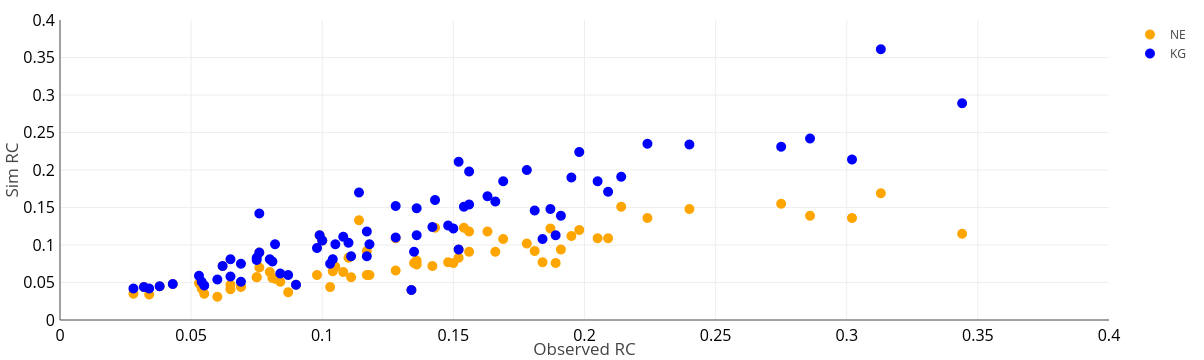

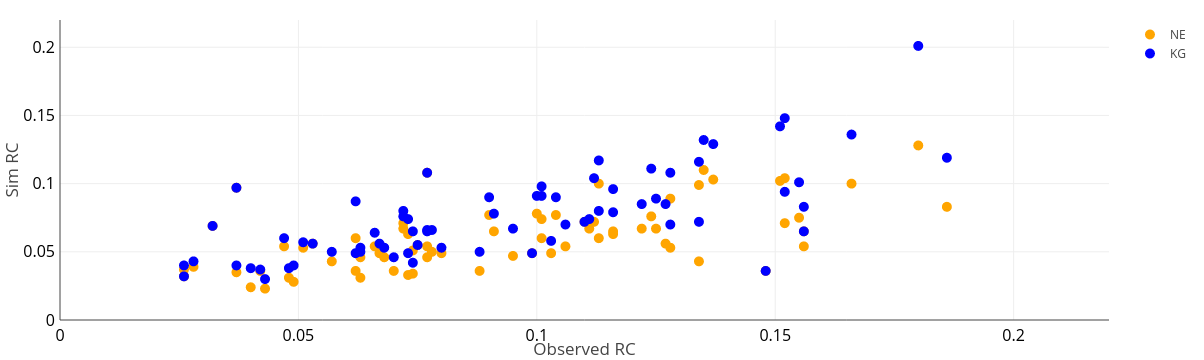

In [248]:

RCobs = [np.around(RCmean, decimals=3), np.around(RCmean, decimals=3)]
RCsim = [np.around(RCbestNEMean, decimals=3), np.around(RCbestKGMean, decimals=3)]
Color = ['orange','blue']
Texto = [['%.1f'%i for i in NEval], ['%.1f'%i for i in KGval]]
Nombres = ['NE', 'KG']

div, fig = Scatter(RCobs, RCsim, Color = Color,multiple=True, width=400, height=300, rangoX=[0, 0.4], 
    rangoY = [0,0.4],size=10, xLabel='Observed RC', yLabel = 'Sim RC', Texto = Texto, Nombres = Nombres)

RCobs = [np.around(RCstd, decimals=3), np.around(RCstd, decimals=3)]
RCsim = [np.around(RCbestNEStd, decimals=3), np.around(RCbestKGStd, decimals=3)]


div, fig = Scatter(RCobs, RCsim, Color = Color,multiple=True, width=400, height=300, rangoX=[0, 0.22], 
    rangoY = [0,0.22],size=10, xLabel='Observed RC', yLabel = 'Sim RC', Texto = Texto, Nombres = Nombres)


In [160]:
coloresEF = ['#0A369C','#508DBA','#88AECA','#C9D8E3','#FCFDFE','#F3D9D5','#EEACA2','#E86653','#AA2714']
rangoRC = np.linspace(0,0.4,9)
RCmeanColors = Remuestreador(RCmean, rangoRC, coloresEF)

rangoStd = np.linspace(0.01, 0.19, 5)
sizes = np.linspace(3.5,8,5)
RCstdSize = Remuestreador(RCstd, rangoStd, sizes)

RCsimKG_meanColors = Remuestreador(RCbestKGMean, rangoRC, coloresEF)
RCsimKG_stdSize = Remuestreador(RCbestKGStd, rangoStd, sizes)

RC_KGmeanDif = 100*(np.array(RCmean) - np.array(RCbestKGMean))/np.array(RCmean)
RC_KGdifColors = Remuestreador(RC_KGmeanDif, np.linspace(-90, 90, 9), coloresEF)

RC_NEmeanDif = 100*(np.array(RCmean) - np.array(RCbestNEMean))/np.array(RCmean)
RC_NEdifColors = Remuestreador(RC_NEmeanDif, np.linspace(-90, 90, 9), coloresEF)

RCsimNE_meanColors = Remuestreador(RCbestNEMean, rangoRC, coloresEF)
RCsimNE_stdSize = Remuestreador(RCbestNEStd, rangoStd, sizes)

In [190]:
rangoRC = np.linspace(0,0.4,9)

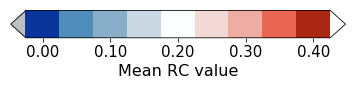

In [196]:
CreateColorbar(coloresEF, ['%.2f' % i for i in rangoRC],path='/home/nicolas/Desktop/RCmeanBar.png', jump=2,label='Mean RC value')

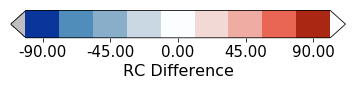

In [197]:
CreateColorbar(coloresEF, ['%.2f' % i for i in np.linspace(-90, 90, 9)],path='/home/nicolas/Desktop/RC_DifBar.png', jump=2,label='RC Difference')

In [179]:
data = []

Texto = ['RCm=%.2f, RCstd=%.2f N=%d' % (i,j,k) for i,j,k in zip(RCmean, RCstd, Nevents)]
# Klin-Gupta colors by performance and by model 
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RCmean',
    mode='markers',
    visible = True,
    marker=dict(
        size= RCstdSize*3.5,
        color = RCmeanColors,
    ),
)
data.append(event_data)

Texto = ['RCm=%.2f, RCstd=%.2f N=%d' % (i,j,k) for i,j,k in zip(RCbestKGMean, RCbestKGStd, Nevents)]
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RC KG',
    mode='markers',
    visible = False,
    marker=dict(
        size= RCsimKG_stdSize*3.5,
        color = RCsimKG_meanColors,
    ),
)
data.append(event_data)

Texto = ['Dif=%.2f KG=%.2f' % (i,j) for i,j in zip(RC_KGmeanDif, KGval)]
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RC KG dif',
    mode='markers',
    visible = False,
    marker=dict(
        size= 15,#RCsimKG_stdSize*3.5,
        color = RC_KGdifColors,
    ),
)
data.append(event_data)

Texto = ['RCm=%.2f, RCstd=%.2f N=%d' % (i,j,k) for i,j,k in zip(RCbestNEMean, RCbestNEStd, Nevents)]
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RC NE',
    mode='markers',
    visible = False,
    marker=dict(
        size= RCsimNE_stdSize*3.5,
        color = RCsimNE_meanColors,
    ),
)
data.append(event_data)

Texto = ['Dif=%.2f NE=%.2f' % (i,j) for i,j in zip(RC_NEmeanDif, NEval)]
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RC NE dif',
    mode='markers',
    visible = False,
    marker=dict(
        size= 15,#RCsimKG_stdSize*3.5,
        color = RC_NEdifColors,
    ),
)
data.append(event_data)


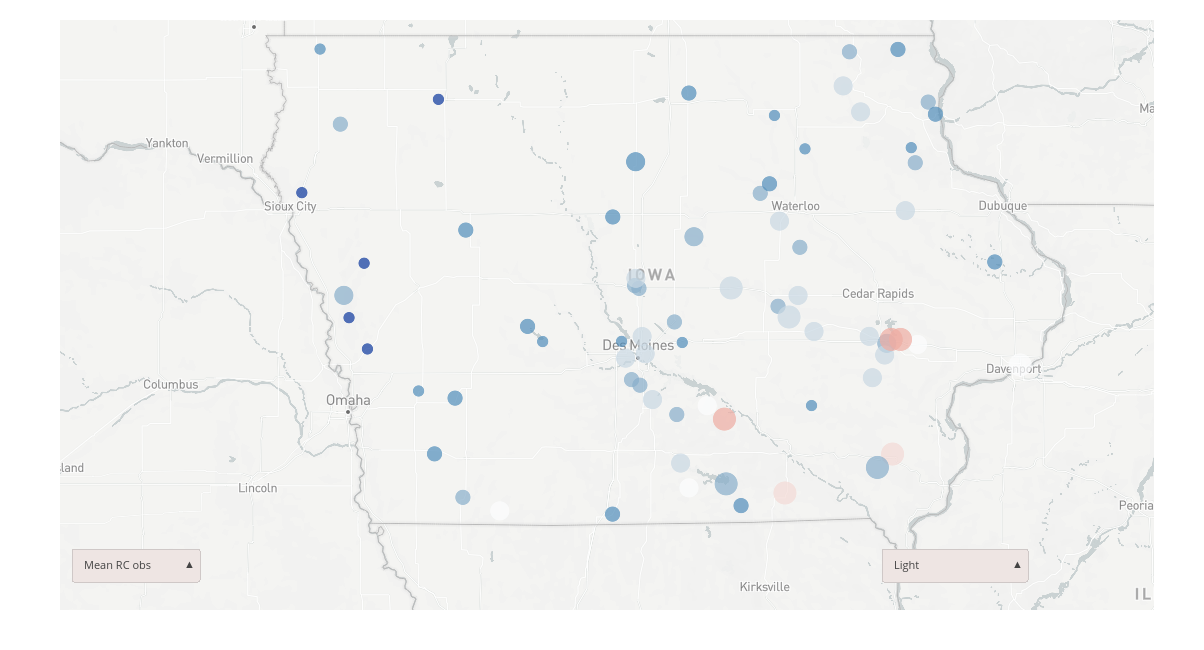

In [181]:
div = PlotMap(data, updatemenus)

# Consistency analysis 

In [251]:
TlValues = np.array(['01','009','007','005','003'])

TlVal = []
TlCount = []
Consistency = []

Lat = []
Lon = []
LinkId = []

MatP50 = []
MatP50model = []

for link in Prop['area'][Prop['area']<2500].index:
    try:
        #Read the distribution of RC p50 to determine the best
        Qobs, Qsim, Events = ReadPickle('/media/nicolas/Data/RunoffExp/Results/Process/RC_'+link+'.bin')
        RcMat = []
        for k in TlValues:
            RcMat.append(Qsim[link][k]['RC_qual'])
        RcMat = np.array(RcMat)

        #Determine the value of the best and the model that corresponds
        RcBest = RcMat.min(axis = 0)
        RcBestPos = RcMat.argmin(axis = 0)
        
        MatP50.append(RcBest.tolist())
        MatP50model.append(TlValues[RcBestPos])
        
        #Calculte the consistency, mode and best model
        Consistency.append(np.abs(np.diff(RcBestPos)).sum())
        Mode = st.mode(RcBestPos)
        TlVal.append(TlValues[Mode.mode[0]])
        TlCount.append(Mode.count[0])
        
        #Coord and link ID
        Lat.append(Prop['coord'][link][0])
        Lon.append(Prop['coord'][link][1])
        LinkId.append(link)
    except:
        pass
MatP50 = np.array(MatP50).T
MatP50model = np.array(MatP50model).T

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning:

invalid value encountered in reduce



In [255]:
data = []

#Colors of the consistency map
ConsistencyColors = []
for c in Consistency:
    ConsistencyColors.append(coloresEF[c])
Texto = ['Tl: %s Con=%d Mode=%d' % (j,i,k) for i,j,k in zip(Consistency, TlVal, TlCount)]
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = '',
    mode='markers',
    visible = True,
    marker=dict(
        size= 15,#RCsimKG_stdSize*3.5,
        color = ConsistencyColors,
    ),
)
data.append(event_data)

colores = ['#0A369C','#88AECA','#FCFDFE','#EEACA2','#AA2714']

for val, tls in zip(MatP50, MatP50model):
    
    val[np.isnan(val)] = np.nanmean(val)
    rango = np.linspace(MatP50.min(), MatP50.max(), 9)
    P50Colors = Remuestreador(val, rango, coloresEF)
    
    Texto = ['Tl: %s DifP50=%.2f' % (i,j) for i,j in zip(tls, val)]
    event_data = go.Scattermapbox(
        lat = Lat,
        lon = Lon,
        text = Texto,
        name = '',
        mode='markers',
        visible = False, 
        marker=dict(
            size= 15,#RCsimKG_stdSize*3.5,
            color = P50Colors,
        ),
    )
    data.append(event_data)

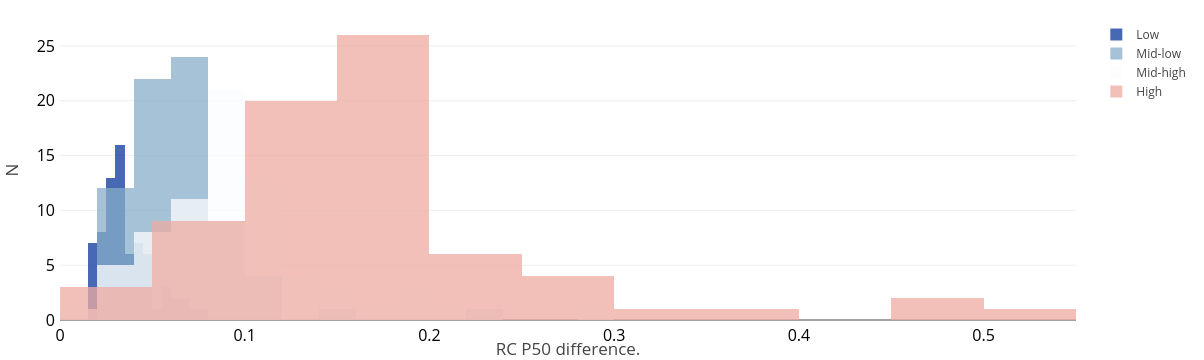

In [287]:
data = []
Nombre = ['Low','Mid-low','Mid-high','High']
for m,c,t in zip(MatP50, coloresEF[::2],Nombre):
    trace= go.Histogram(
        x = m,
        opacity = 0.75,
        name = t,
        marker = dict(
            color = c,
        ),
    )
    data.append(trace)
layout = go.Layout(
    barmode='overlay',
    width = 700,
    height = 350,
    yaxis=dict(
            title='N',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = 'RC P50 difference.',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
            ),),
        margin=dict(
            l=60,
            r=50,
            b=40,
            t=20,
            pad=4
        ),
    )
fig = go.Figure(data=data, layout=layout)
config={'showLink': False}
iplot(fig, config = config)
div = plot(fig, include_plotlyjs=False, output_type='div', config = config)
    

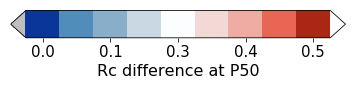

In [226]:
CreateColorbar(coloresEF, ['%.1f'%i for i in rango], '/home/nicolas/Desktop/DifP50RCLevels.png', jump=2, label='Rc difference at P50')

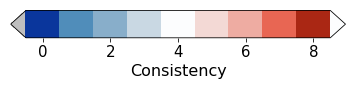

In [224]:
CreateColorbar(coloresEF, np.arange(9), '/home/nicolas/Desktop/ConsistencyBar.png', jump=2, label='Consistency')

In [253]:
updatemenus=list([
    # drop-down 1: map styles menu
    # buttons containes as many dictionaries as many alternative map styles I want to offer
    dict(
        buttons=list([
            dict(
                args=['mapbox.style', 'light'],
                label='Light',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'dark'],
                label='Dark',
                method='relayout'
            ),                                
            dict(
                args=['mapbox.style', 'outdoors'],
                label='Outdoors',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'satellite-streets'],
                label='Satellite with Streets',
                method='relayout'
            )                    
        ]),
        # direction where I want the menu to expand when I click on it
        direction = 'up',
      
        # here I specify where I want to place this drop-down on the map
        x = 0.75,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
      
        # specify font size and colors
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    ), 
    # drop-down 2: select type of storm event to visualize
    dict(
         # for each button I specify which dictionaries of my data list I want to visualize. Remember I have 7 different
         # types of storms but I have 8 options: the first will show all of them, while from the second to the last option, only
         # one type at the time will be shown on the map
         buttons=list([
            dict(label = 'Consistency',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False]}]),
            dict(label = 'Low events',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False]}]),
             dict(label = 'Mid low',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False]}]),
             dict(label = 'Mid High',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False]}]),
             dict(label = 'High',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, True]}]),
        ]),
        # direction where the drop-down expands when opened
        direction = 'up',
        # positional arguments
        x = 0.01,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
        # fonts and border
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    )

])

# SCS CN analysis 

In [346]:
import scipy.optimize as opt

In [347]:
def CN_obtain_S(CN,alfa = 0.05):
    S = 25.4*((1000./CN) - 10.)
    Ia = alfa*S
    return S, Ia
def CN_compareQ(CN,P,Qo):
    S,Ia = CN_obtain_S(CN)
    Qs = ((P - Ia)**2.)/(P - Ia + S)
    return Qo - Qs

In [367]:
Qobs, Qsim, Eventos = ReadPickle('/media/nicolas/Data/RunoffExp/Results/Process/RC_227265.bin')
Area = Prop['area']['227265']

In [423]:
%%time
RCmean = []
RCstd = []
Lat = []
Lon = []
LinkId = []
Nevents = []
CNmean = []
CNstd = []
CNrange = []
Areas = []

#for link in Prop['area'][Prop['area']<4500].index:
for link in Prop.index:
    try:
        #Read data
        Qobs, Qsim, Events = ReadPickle(path + 'RC_'+link+'.bin')
        Area = Prop['area'][link]
        Areas.append(Area)
        #Obtain the CN 
        CN = []
        for p1, p2 in zip(Events[link]['p1'], Events[link]['p2']):
            try:
                #Estimate total mm of runoff 
                Q = Qobs[link]['BR']['Runoff'][p1:p2].sum()*3600/(Area*1e3)
                # Estimates total rainfall 
                P = Qobs[link]['Rain'][p1]
                #Obtaines CN
                CN.append(opt.bisect(CN_compareQ, 40,100, args=(P, Q)))
            except:
                pass
        CN = np.array(CN) 
        CN=CN[np.isfinite(CN)]
        CNmean.append(np.nanmean(CN))
        CNstd.append(np.nanstd(CN))
        CNrange.append(np.percentile(CN,75) - np.percentile(CN,25))
        
        Nevents.append(Qobs[link]['RC'].size)
        RCmean.append(Qobs[link]['RC'].mean())
        RCstd.append(Qobs[link]['RC'].std())
        
        #Coord and link ID
        Lat.append(Prop['coord'][link][0])
        Lon.append(Prop['coord'][link][1])
        LinkId.append(link)
    except:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning:

Degrees of freedom <= 0 for slice.



CPU times: user 2.84 s, sys: 450 ms, total: 3.29 s
Wall time: 4.13 s


In [424]:
CNmean = np.array(CNmean)
CNmean[np.isnan(CNmean)] = np.nanmean(CNmean)

CNstd = np.array(CNstd)
CNstd[np.isnan(CNstd)] = np.nanmean(CNstd)

In [442]:
np.max(CNrange)

33.94990390270095

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:448: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



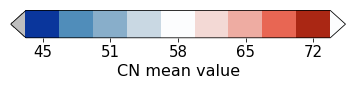

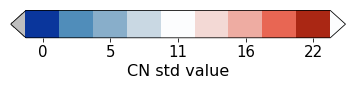

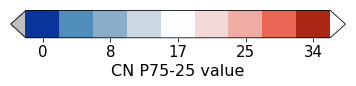

In [451]:
CN_mean_colors = Remuestreador(CNmean, np.linspace(45, 72, 9), coloresEF)
t = ['%d'%i for i in np.linspace(45, 72, 9)]
CreateColorbar(coloresEF, t, '/home/nicolas/Desktop/CN_mean_Cbar.png', label='CN mean value')

CN_std_colors = Remuestreador(CNstd, np.linspace(0, 22, 9), coloresEF)
t = ['%d'%i for i in np.linspace(0, 22, 9)]
CreateColorbar(coloresEF, t, '/home/nicolas/Desktop/CN_std_Cbar.png', label = 'CN std value')

CN_range_colors = Remuestreador(CNstd, np.linspace(0, 34, 9), coloresEF)
t = ['%d'%i for i in np.linspace(0, 34, 9)]
CreateColorbar(coloresEF, t, '/home/nicolas/Desktop/CN_range_Cbar.png', label = 'CN P75-25 value')


In [447]:
data = []

Texto = ['CNm=%.2f, CNstd=%.2f' % (i,j) for i,j in zip(CNmean, CNstd)]
# Klin-Gupta colors by performance and by model 
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RCmean',
    mode='markers',
    visible = True,
    marker=dict(
        size= 15,
        color = CN_mean_colors,
    ),
)
data.append(event_data)

Texto = ['CNm=%.2f, CNstd=%.2f' % (i,j) for i,j in zip(CNmean, CNstd)]
# Klin-Gupta colors by performance and by model 
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RCmean',
    mode='markers',
    visible = False,
    marker=dict(
        size= 15,
        color = CN_std_colors,
    ),
)
data.append(event_data)

Texto = ['CNrange=%.2f' % i for i in CNrange]
# Klin-Gupta colors by performance and by model 
event_data = go.Scattermapbox(
    lat = Lat,
    lon = Lon,
    text = Texto,
    name = 'RCmean',
    mode='markers',
    visible = False,
    marker=dict(
        size= 15,
        color = CN_range_colors,
    ),
)
data.append(event_data)

In [448]:
updatemenus=list([
    # drop-down 1: map styles menu
    # buttons containes as many dictionaries as many alternative map styles I want to offer
    dict(
        buttons=list([
            dict(
                args=['mapbox.style', 'light'],
                label='Light',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'dark'],
                label='Dark',
                method='relayout'
            ),                                
            dict(
                args=['mapbox.style', 'outdoors'],
                label='Outdoors',
                method='relayout'
            ),
            dict(
                args=['mapbox.style', 'satellite-streets'],
                label='Satellite with Streets',
                method='relayout'
            )                    
        ]),
        # direction where I want the menu to expand when I click on it
        direction = 'up',
      
        # here I specify where I want to place this drop-down on the map
        x = 0.75,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
      
        # specify font size and colors
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    ), 
    # drop-down 2: select type of storm event to visualize
    dict(
         # for each button I specify which dictionaries of my data list I want to visualize. Remember I have 7 different
         # types of storms but I have 8 options: the first will show all of them, while from the second to the last option, only
         # one type at the time will be shown on the map
         buttons=list([
            dict(label = 'Mean CN',
                 method = 'update',
                 args = [{'visible': [True, False, False]}]),
            dict(label = 'Std CN',
                 method = 'update',
                 args = [{'visible': [False, True, False]}]),
            dict(label = 'Range 25-75 CN',
                 method = 'update',
                 args = [{'visible': [False, False, True]}]),
        ]),
        # direction where the drop-down expands when opened
        direction = 'up',
        # positional arguments
        x = 0.01,
        xanchor = 'left',
        y = 0.05,
        yanchor = 'bottom',
        # fonts and border
        bgcolor = '#EEE5E3',
        bordercolor = '#CFC8C7',
        font = dict(size=11)
    )

])

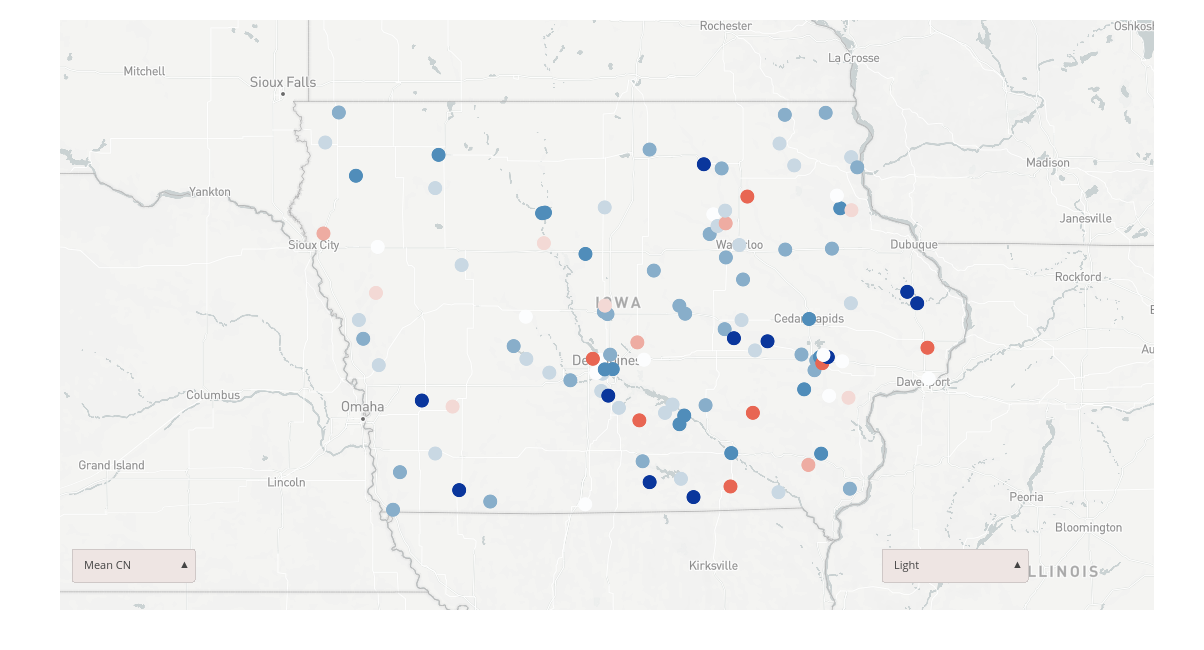

In [449]:
div = PlotMap(data, updatemenus)

In [450]:
div

'<div id="def0d861-361f-47ab-a30b-8d515d8da18f" style="height: 650px; width: 850px;" class="plotly-graph-div"></div><script type="text/javascript">window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("def0d861-361f-47ab-a30b-8d515d8da18f", [{"type": "scattermapbox", "lat": [41.778597, 40.64028, 42.753875, 41.687209, 41.676682, 43.207278, 41.680544, 42.065821, 41.546144, 42.006653, 41.613878, 41.669603, 43.164962, 43.421084, 42.572759, 41.589432, 42.314984, 41.606405, 41.718346, 43.111927, 41.581656, 42.711925, 41.457907, 43.062195, 43.054188, 41.355699, 41.423139, 40.769466, 40.95189, 42.164405, 42.008878, 42.023042, 42.495542, 42.432475, 41.424158, 42.629426, 41.964432, 41.681378, 43.128026, 41.010848, 40.925305, 41.766974, 42.648316, 41.688322, 40.692517, 42.57666, 43.03328, 41.388961, 43.406913, 40.660543, 41.830544, 42.723582, 42.156934, 41.469739, 40.873055, 41.971945, 41.006973, 42.508303, 42.73722, 41.587211, 41.988039, 40.825011, 41